In [113]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import moviepy.video.io.ImageSequenceClip
import pandas as pd
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [69]:
raw_data = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

In [79]:
raw_data.columns

Index(['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol',
       'fasting blood sugar', 'resting ecg', 'max heart rate',
       'exercise angina', 'oldpeak', 'ST slope', 'target'],
      dtype='object')

In [80]:
# choose some features
features_names = ['age', 'sex', 'resting bp s', 'fasting blood sugar', 'resting ecg']
input_data = raw_data[features_names].to_numpy()
target = raw_data['target'].to_numpy()

In [97]:
scaler = StandardScaler()
input_data_std = scaler.fit_transform(input_data)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(input_data_std), torch.tensor(target), stratify=target, shuffle=True,
                                                    test_size=0.2)

In [99]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=1, shuffle=False)

In [100]:
train_inputs = torch.empty(len(train_loader), 5, device=device)
train_labels = torch.empty(len(train_loader), dtype=torch.long, device=device)
test_inputs = torch.empty(len(test_loader), 5, device=device)
test_labels = torch.empty(len(test_loader), dtype=torch.long, device=device)

# Fill tensors with data
for i, (data, labels) in enumerate(train_loader):
    train_inputs[i] = data.squeeze(0).to(device)
    train_labels[i] = labels.to(device)

for i, (data, labels) in enumerate(test_loader):
    test_inputs[i] = data.squeeze(0).to(device)
    test_labels[i] = labels.to(device)

dataset = {
    'train_input': train_inputs,
    'test_input': test_inputs,
    'train_label': train_labels,
    'test_label': test_labels
}

In [101]:
print('feature ->', features_names)
print('classes ->', raw_data['target'].unique())

# Changing name as it don't yet have function to set font size
features = ['age', 'sex', 'bp', 'sugar', 'ecg']
classes = ['No', 'Yes']

feature -> ['age', 'sex', 'resting bp s', 'fasting blood sugar', 'resting ecg']
classes -> [0 1]


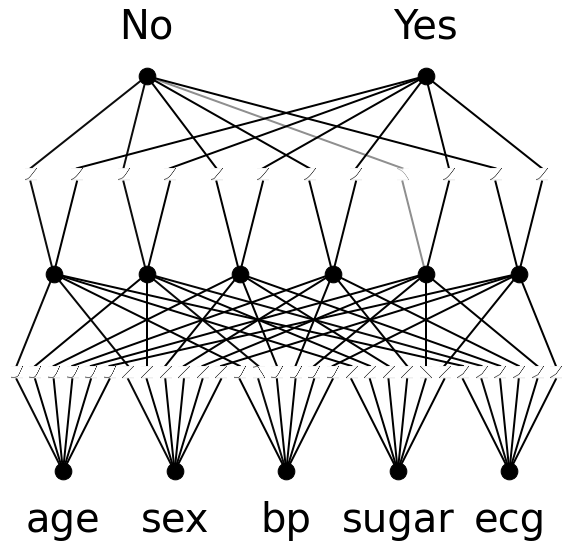

In [153]:
model = KAN(width=[5, 6, 2], grid=3, k=3, seed=0, device=device)

model(dataset['train_input'])

model.plot(beta=100, scale=1, in_vars=features, out_vars=classes)

In [154]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

train loss: 7.73e-01 | test loss: 7.55e-01 | reg: 6.68e+01 :  52%|▌| 52/100 [05:45<05:19,  6.65s/it]


MemoryError: Unable to allocate 7.31 MiB for an array with shape (684, 700, 4) and data type float32

Error in callback <function _draw_all_if_interactive at 0x000001B70395D940> (for post_execute):


MemoryError: Unable to allocate 7.31 MiB for an array with shape (684, 700, 4) and data type float32

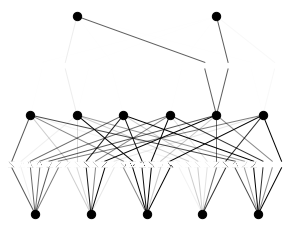

In [155]:
results = model.train(dataset, opt="Adam", device=device, metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=50, lamb=0.01, lamb_entropy=10., save_fig=True, img_folder='heart')

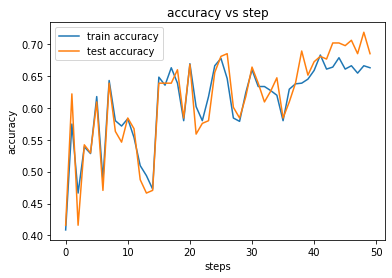

Text(0, 0.5, 'loss')

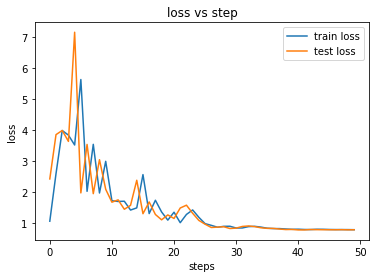

In [107]:
plt.plot(results['train_acc'], label='train accuracy')
plt.plot(results['test_acc'], label = 'test accuracy')
plt.legend()
plt.title('accuracy vs step')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.show()

plt.plot(results['train_loss'], label='train loss')
plt.plot(results['test_loss'], label = 'test loss')
plt.legend()
plt.title('loss vs step')
plt.xlabel('steps')
plt.ylabel('loss')

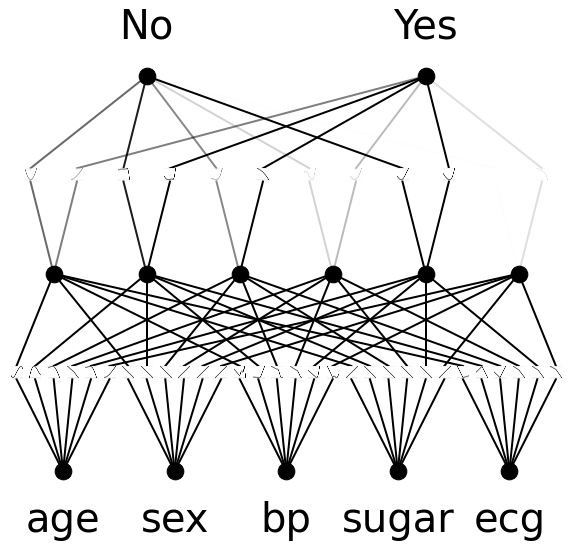

In [109]:
model.plot(beta=100, scale=1, in_vars=features, out_vars=classes)

In [152]:
model.prune()
model.plot(mask=True)

AttributeError: 'MLP' object has no attribute 'prune'

In [110]:
video_name='video'
fps=10

fps = fps
files = os.listdir('heart')
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = ['heart'+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


In [142]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(5, 6)  # 4 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(6, 2)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        # Cast parameters to the same data type as input tensor
        x = self.fc1(x.to(self.fc1.weight.dtype))
        x = self.relu(x)
        x = self.fc2(x.to(self.fc2.weight.dtype))
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    model.train()
    train_losses = []
    test_losses = []
    test_accuracies = []
    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Test the model
        test_loss, test_accuracy = test_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%')
    return train_losses, test_losses, test_accuracies

def test_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item() * labels.size(0)
    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    return test_loss, accuracy

In [143]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, test_accuracies = train_model(model, train_loader, criterion, optimizer)

test_loss, test_accuracy = test_model(model, test_loader, criterion)

Epoch 1, Train Loss: 0.6668742480492141, Test Loss: 0.6042293184319464, Test Accuracy: 73.94957983193277%
Epoch 2, Train Loss: 0.6129652022094536, Test Loss: 0.570138438409116, Test Accuracy: 75.21008403361344%
Epoch 3, Train Loss: 0.6002187271007657, Test Loss: 0.5623823574454594, Test Accuracy: 75.63025210084034%
Epoch 4, Train Loss: 0.595722917608228, Test Loss: 0.5597621752183979, Test Accuracy: 76.05042016806723%
Epoch 5, Train Loss: 0.5935541377128923, Test Loss: 0.5583795448530371, Test Accuracy: 75.21008403361344%
Epoch 6, Train Loss: 0.5918733175343075, Test Loss: 0.5586252982000343, Test Accuracy: 76.05042016806723%
Epoch 7, Train Loss: 0.5916633205879637, Test Loss: 0.5576072294077202, Test Accuracy: 73.94957983193277%
Epoch 8, Train Loss: 0.5896892018201408, Test Loss: 0.5589038418652881, Test Accuracy: 73.10924369747899%
Epoch 9, Train Loss: 0.589339469731668, Test Loss: 0.5570742939794514, Test Accuracy: 73.10924369747899%
Epoch 10, Train Loss: 0.5895731581116737, Test Lo

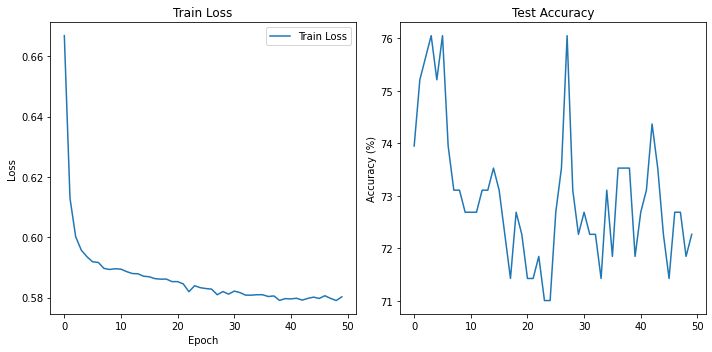

In [151]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')

plt.tight_layout()
plt.show()